# Import of all the librairie

In [3]:
# Lib import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from math import sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import data with pandas

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/ACTINSPACE - CleanAir/AirQo/'

In [6]:
dataset = pd.read_csv(path+'sample_dataset.csv')

In [7]:
dataset.head(5)

,Unnamed: 0,channel_id,pm2_5,pm10,s2_pm2_5,s2_pm10,Site,TimeStamp
0,0,912223,37.02,45.23,34.07,39.82,"Banda, Kampala",2019-11-27 13:24:45
1,1,912223,37.02,45.23,34.07,39.82,"Banda, Kampala",2019-11-27 13:24:45
2,2,912223,41.70,50.70,38.55,47.43,"Banda, Kampala",2019-11-27 13:26:13
3,3,912223,41.70,50.70,38.55,47.43,"Banda, Kampala",2019-11-27 13:26:13
4,4,912223,42.15,52.87,40.55,49.95,"Banda, Kampala",2019-11-27 13:30:53


In [8]:
dataset.shape

(23567841, 8)

# Pre-processing

We have 23567841 row of data, we can see that we have an dupplicated data in firt row. So we will remove all the duplicated data in the dataset.

In [9]:
# Remove all the duplicates row
# 37 057 data duplicate
dataset = dataset.drop_duplicates()

In [10]:
dataset = dataset[['channel_id','pm2_5','pm10','s2_pm2_5','s2_pm10','Site','TimeStamp']]

In [11]:
# Remove all the duplicates row
# 37 057 data duplicate
dataset = dataset.drop_duplicates()

In [12]:
#dataset['TimeStamp'] = dataset['TimeStamp'].astype(str)

In [13]:
dataset.dtypes

channel_id      int64
pm2_5         float64
pm10          float64
s2_pm2_5      float64
s2_pm10       float64
Site           object
TimeStamp      object
dtype: object

In [14]:
def split_date(x):
    try:
        d = x.split()
        return d[0]+ ' ' + d[1].split(':')[0]
    except:
        return '2019-01-12 00'
# Assiciate Date for each hour
dataset['Date_Hour'] = dataset['TimeStamp'].apply(split_date)

In [15]:
dataset

,channel_id,pm2_5,pm10,s2_pm2_5,s2_pm10,Site,TimeStamp,Date_Hour
0,912223,37.02,45.23,34.07,39.82,"Banda, Kampala",2019-11-27 13:24:45,2019-11-27 13
2,912223,41.70,50.70,38.55,47.43,"Banda, Kampala",2019-11-27 13:26:13,2019-11-27 13
4,912223,42.15,52.87,40.55,49.95,"Banda, Kampala",2019-11-27 13:30:53,2019-11-27 13
6,912223,45.10,57.02,44.75,55.03,"Banda, Kampala",2019-11-27 13:32:22,2019-11-27 13
8,912223,41.72,52.08,40.00,49.20,"Banda, Kampala",2019-11-27 13:33:46,2019-11-27 13
...,...,...,...,...,...,...,...,...
23567836,730016,81.33,87.83,62.63,75.42,"Wobulenzi west, Luwero",2021-11-15 13:38:11,2021-11-15 13
23567837,730016,57.38,64.48,41.63,55.15,"Wobulenzi west, Luwero",2021-11-15 13:39:33,2021-11-15 13
23567838,730016,43.15,52.15,33.37,43.23,"Wobulenzi west, Luwero",2021-11-15 13:41:03,2021-11-15 13
23567839,730016,46.45,56.95,38.78,52.30,"Wobulenzi west, Luwero",2021-11-15 13:42:26,2021-11-15 13


In [16]:
rigth_dataset = dataset.groupby(["channel_id","Site","Date_Hour"]).median()
rigth_dataset = rigth_dataset.reset_index()
#sites_metadata.csv
rigth_dataset

,channel_id,Site,Date_Hour,pm2_5,pm10,s2_pm2_5,s2_pm10
0,672528,"Kasharara, Rubirizi",2019-01-12 11,23.58,25.670,17.570,17.63
1,672528,"Kasharara, Rubirizi",2019-01-12 12,22.42,23.870,15.630,17.68
2,672528,"Kasharara, Rubirizi",2019-01-14 15,94.93,100.830,82.180,88.33
3,672528,"Kasharara, Rubirizi",2019-01-14 16,89.57,103.430,97.850,106.97
4,672528,"Kasharara, Rubirizi",2019-01-14 17,135.20,157.000,137.650,144.82
...,...,...,...,...,...,...,...
596163,930427,"Luwafu, Makindye",2021-11-16 02,37.00,44.850,35.320,44.77
596164,930427,"Luwafu, Makindye",2021-11-16 03,44.29,55.315,42.535,54.88
596165,930427,"Luwafu, Makindye",2021-11-16 04,43.80,55.170,42.230,53.25
596166,930427,"Luwafu, Makindye",2021-11-16 05,46.00,58.170,43.850,58.22


Imputation of missing data in site metadata. We juste use to impute by the close site

In [18]:
cols = ['greenness', 'landform_90', 'landform_270', 'aspect',
       'distance_to_nearest_road', 'distance_to_nearest_primary_road',
       'distance_to_nearest_tertiary_road',
       'distance_to_nearest_unclassified_road',
       'distance_to_nearest_residential_road',
       'distance_to_nearest_secondary_road', 'distance_to_kampala_center',
       'bearing_to_kampala_center']
sites_data = pd.read_csv(path+'sites_metadata.csv')
sites_data.drop('formatted_name',axis=1,inplace=True)
columss = list(sites_data.columns)
columss[0]='Site'
sites_data.columns = columss

def proces_site_data(col,sites_data):
    
    for one_site in sites_data[sites_data[col].isna()].values:

        distance_max = 0
        data_to_replace = None
        for one_other_site in sites_data[sites_data[col].notna()].values:
            
            x1 = one_site[1]
            x2 = one_other_site[2]
            y1 = one_site[1]
            y2 = one_other_site[2]
            dist = sqrt((x2 - x1)**2 + (y2 - y1)**2)
            if distance_max < dist:
                dist = distance_max
                dd = sites_data[sites_data[col].notna()]
                
                data_to_replace = dd.loc[dd['Site']==one_other_site[0]][col].values[0]
        
        dd = sites_data[sites_data[col].isna()]
        sites_data.loc[dd[dd['Site']==one_site[0]].index,col] = data_to_replace
    
    return sites_data
for c in cols:
    sites_data = proces_site_data(c,sites_data)   
sites_data

,Site,latitude,longitude,country,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center
0,"Bweyogerere, Kira Municipality",0.350100,32.666200,Uganda,Central Region,Wakiso,Kampala,Kampala,Bweyogerere Division,Bweyogerere,NaN,1166.513916,3293.4,31.0,-2.0,240.95,16.95,1044.70,454.06,448.69,16.95,29.06,9.494684,67.293040
1,"Kasharara, Rubirizi",-0.265089,30.106887,Uganda,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.10,396.87,542.79,27.70,283.538298,256.793325
2,"Central Division, Tororo",0.693930,34.181350,Uganda,Eastern Region,Tororo,Tororo,Tororo,Western division,Central,Bazaar Street,1200.667969,2875.3,24.0,3.0,63.44,12.12,12.12,371.40,12.86,58.59,92.69,182.252178,76.693245
3,"Nyahuka, Bundibugyo",0.674056,29.994029,Uganda,Western Region,Bundibugyo,Nyahuka,Bundibugyo,Nyahuka town council,Bundimulinga,Fort Portal - Bundibugyo - Lamia Road,850.974853,6535.0,31.0,-9.0,300.96,2.80,2.80,371.40,110.89,26.33,27.70,291.371007,277.846159
4,"Kisanga, Kasese",0.178013,30.083665,Uganda,Western Region,Kasese,Kasese,Kasese,Nyamwamba division,Kisanga,Unnamed Road,980.737549,3249.0,34.0,-3.0,270.00,12.65,281.70,436.20,83.68,12.65,27.70,279.140439,266.825334
5,"Rwengoma, Kabarole",0.657624,30.267630,Uganda,Western Region,Kabarole,Fort Portal,Kabarole,Western division,Rwengoma,NaN,1521.848877,5558.0,21.0,-5.0,26.57,17.61,248.39,614.33,36.12,17.61,910.22,260.960315,278.358776
6,"Masaba, Mbale Industrial division",1.076072,34.161669,Uganda,Eastern Region,Mbale,Mbale,Mbale,Industrial division,Masaba,NaN,1122.573730,3598.0,21.0,3.0,180.00,14.78,14.78,684.45,425.79,202.74,328.38,194.286464,64.251853
7,"Bugana, Namayingo",0.201919,33.817240,Uganda,Eastern Region,Namayingo,Bubanyi,Namayingo,Bugana,Bugana,Unnamed Road,1156.139526,5854.0,24.0,6.0,80.54,27.70,1044.70,371.40,560.45,27.90,27.70,137.491012,95.349672
8,"Buloli North, Bududa",1.011247,34.331200,Uganda,Eastern Region,Bududa,Bushinyekwa,Bududa,Bududa town council,Buloli north,NaN,1299.041382,5375.0,31.0,-25.0,71.57,4.35,1044.70,74.99,96.72,5.76,4.35,208.723676,68.285189
9,"Bukikali,Lwaso Mbale",1.083978,34.233655,Uganda,Eastern Region,Mbale,NaN,Mbale,Lwasso,Bukikali,NaN,1439.790000,6911.0,21.0,1.0,152.59,3.80,1044.70,3.80,17.07,18.19,27.70,201.908382,65.013083


In [19]:
# Make all the row data
from datetime import date, timedelta

start_date = date(2019, 1, 12) 
end_date = date(2021, 11, 25)    # perhaps date.now()

# start_date = date(2021, 1, 1) 
# end_date = date(2021, 11, 25)


delta = end_date - start_date   # returns timedelta


dict_ = {'channel_id':[],'Site':[],'Date_Hour':[]}
cs = rigth_dataset[['channel_id','Site']].drop_duplicates().values
for i in range(delta.days + 1):
    # print(i)
    day = start_date + timedelta(days=i)
    #check = [tuple(y) for y in train_data.values[:,:3]]
    for h in range(24):
        Date_Hour = str(day)+' '+str(h).zfill(2)
        for site in cs:
            #dict_ = {}
                
            dict_['channel_id'].append(site[0])
            dict_['Site'].append(site[1])
            dict_['Date_Hour'].append(Date_Hour)
            #print(check)
            #print('Oui')
                
                
test_data = pd.DataFrame(dict_)
test_data

,channel_id,Site,Date_Hour
0,672528,"Kasharara, Rubirizi",2019-01-12 00
1,675801,"Central Division, Tororo",2019-01-12 00
2,675805,"Nyahuka, Bundibugyo",2019-01-12 00
3,675991,"Kisanga, Kasese",2019-01-12 00
4,676000,"Rwengoma, Kabarole",2019-01-12 00
...,...,...,...
1057387,912223,"Banda, Kampala",2021-11-25 23
1057388,912224,"Nantabulirwa ward, Mukono",2021-11-25 23
1057389,912225,"Kasenge, Wakiso",2021-11-25 23
1057390,930426,"Mbalwa, Kira Municipality",2021-11-25 23


In [20]:
# Merge to site metadata
all_data = test_data.merge(rigth_dataset,on=['channel_id','Site','Date_Hour'],how='left')
all_data = all_data.merge(sites_data,on=['Site'],how='left')

In [21]:
all_data['Year'] = all_data['Date_Hour'].apply(lambda x: x.split()[0].split('-')[0] )
all_data['Mouth'] = all_data['Date_Hour'].apply(lambda x: x.split()[0].split('-')[1] )
all_data['Day'] = all_data['Date_Hour'].apply(lambda x: x.split()[0].split('-')[2] )

In [22]:
# Because of the large volume of data and he limit of the performence machine, we will use only the data of 2021 to train our model
all_data = all_data[all_data['Year']=='2021']

In [23]:
# All the columns for the train
cols_train = ['channel_id', 'country', 'Year', 'latitude', 'longitude', 'region',
       'district',
       'altitude', 'greenness', 'landform_90', 'landform_270', 'aspect',
       'distance_to_nearest_road', 'distance_to_nearest_primary_road',
       'distance_to_nearest_tertiary_road',
       'distance_to_nearest_unclassified_road',
       'distance_to_nearest_residential_road',
       'distance_to_nearest_secondary_road', 'distance_to_kampala_center',
       'bearing_to_kampala_center', 'Mouth', 'Day']

In [24]:
# Get all the none data
dataset_to_estimate = all_data[all_data.s2_pm2_5.isnull()]
dataset_to_estimate

,channel_id,Site,Date_Hour,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,country,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center,Year,Mouth,Day
725760,672528,"Kasharara, Rubirizi",2021-01-01 00,NaN,NaN,NaN,NaN,-0.265089,30.106887,Uganda,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.10,396.87,542.79,27.70,283.538298,256.793325,2021,01,01
725765,689516,"Masaba, Mbale Industrial division",2021-01-01 00,NaN,NaN,NaN,NaN,1.076072,34.161669,Uganda,Eastern Region,Mbale,Mbale,Mbale,Industrial division,Masaba,NaN,1122.573730,3598.0,21.0,3.0,180.00,14.78,14.78,684.45,425.79,202.74,328.38,194.286464,64.251853,2021,01,01
725766,689522,"Bugana, Namayingo",2021-01-01 00,NaN,NaN,NaN,NaN,0.201919,33.817240,Uganda,Eastern Region,Namayingo,Bubanyi,Namayingo,Bugana,Bugana,Unnamed Road,1156.139526,5854.0,24.0,6.0,80.54,27.70,1044.70,371.40,560.45,27.90,27.70,137.491012,95.349672,2021,01,01
725767,689525,"Buloli North, Bududa",2021-01-01 00,NaN,NaN,NaN,NaN,1.011247,34.331200,Uganda,Eastern Region,Bududa,Bushinyekwa,Bududa,Bududa town council,Buloli north,NaN,1299.041382,5375.0,31.0,-25.0,71.57,4.35,1044.70,74.99,96.72,5.76,4.35,208.723676,68.285189,2021,01,01
725768,689530,"Bukikali,Lwaso Mbale",2021-01-01 00,NaN,NaN,NaN,NaN,1.083978,34.233655,Uganda,Eastern Region,Mbale,NaN,Mbale,Lwasso,Bukikali,NaN,1439.790000,6911.0,21.0,1.0,152.59,3.80,1044.70,3.80,17.07,18.19,27.70,201.908382,65.013083,2021,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057387,912223,"Banda, Kampala",2021-11-25 23,NaN,NaN,NaN,NaN,0.341674,32.635306,Uganda,Central Region,Kampala,Kampala,Kampala,Nakawa division,Banda,Jinja Road,1165.034424,2451.6,41.0,-18.0,198.44,39.18,1044.70,87.35,399.92,76.49,356.19,5.979126,62.000000,2021,11,25
1057388,912224,"Nantabulirwa ward, Mukono",2021-11-25 23,NaN,NaN,NaN,NaN,0.346460,32.703280,Uganda,Central Region,Mukono,NaN,Mukono,Goma division,Nantabulirwa ward,Unnamed Road,1182.829102,5762.0,21.0,2.0,183.18,26.76,1044.70,181.05,637.59,26.76,271.13,13.296376,75.000000,2021,11,25
1057389,912225,"Kasenge, Wakiso",2021-11-25 23,NaN,NaN,NaN,NaN,0.286595,32.506107,Uganda,Central Region,Wakiso,Kyengera,Wakiso,Kyengera town council,Kasenge,Unnamed Road,1198.859131,4824.0,21.0,2.0,114.15,16.76,1044.70,328.24,16.76,33.61,27.70,9.663299,249.000000,2021,11,25
1057390,930426,"Mbalwa, Kira Municipality",2021-11-25 23,NaN,NaN,NaN,NaN,0.365500,32.646800,Uganda,Central Region,Wakiso,Kampala,Kampala,Namugongo Division,Kyaliwajjala,Kampala - Northern Bypass Highway,1188.213013,3709.8,31.0,1.0,216.03,33.39,1044.70,123.69,227.46,33.39,203.55,8.500316,50.000000,2021,11,25


In [25]:
# Get all the complete data
dataset_to_train = all_data.loc[list(set(all_data.index) - set(dataset_to_estimate.index))]
#dataset_to_train.fillna(dataset_to_train.mean(), inplace = True)
dataset_to_train

,channel_id,Site,Date_Hour,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,country,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center,Year,Mouth,Day
1048578,689522,"Bugana, Namayingo",2021-11-17 06,16.910,18.485,17.720,19.475,0.201919,33.817240,Uganda,Eastern Region,Namayingo,Bubanyi,Namayingo,Bugana,Bugana,Unnamed Road,1156.139526,5854.0,24.0,6.0,80.54,27.70,1044.70,371.40,560.45,27.90,27.70,137.491012,95.349672,2021,11,17
1048579,689525,"Buloli North, Bududa",2021-11-17 06,39.050,48.425,43.375,51.885,1.011247,34.331200,Uganda,Eastern Region,Bududa,Bushinyekwa,Bududa,Bududa town council,Buloli north,NaN,1299.041382,5375.0,31.0,-25.0,71.57,4.35,1044.70,74.99,96.72,5.76,4.35,208.723676,68.285189,2021,11,17
1048580,689530,"Bukikali,Lwaso Mbale",2021-11-17 06,41.800,52.785,45.200,56.025,1.083978,34.233655,Uganda,Eastern Region,Mbale,NaN,Mbale,Lwasso,Bukikali,NaN,1439.790000,6911.0,21.0,1.0,152.59,3.80,1044.70,3.80,17.07,18.19,27.70,201.908382,65.013083,2021,11,17
1048581,689750,"Bumurwa, Namisindwa",2021-11-17 06,21.230,26.420,33.830,40.550,0.926080,34.361830,Uganda,Eastern Region,Manafwa,NaN,Manafwa,NaN,NaN,Unnamed Road,1482.789185,3293.4,31.0,-20.0,240.95,27.70,1044.70,371.40,560.45,27.90,27.70,5.334824,179.000000,2021,11,17
1048582,689752,"Bwole Ward, Bugiri",2021-11-17 06,29.940,32.100,29.420,31.305,0.567539,33.751720,Uganda,Eastern Region,Bugiri,Bugiri,Bugiri,Western division,Bwole ward,NaN,1130.966309,2107.0,34.0,-1.0,90.00,6.77,6.77,218.50,82.64,12.50,27.70,132.527692,77.858144,2021,11,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,930426,"Mbalwa, Kira Municipality",2021-11-17 05,72.905,78.975,74.980,80.765,0.365500,32.646800,Uganda,Central Region,Wakiso,Kampala,Kampala,Namugongo Division,Kyaliwajjala,Kampala - Northern Bypass Highway,1188.213013,3709.8,31.0,1.0,216.03,33.39,1044.70,123.69,227.46,33.39,203.55,8.500316,50.000000,2021,11,17
1048572,672528,"Kasharara, Rubirizi",2021-11-17 06,38.015,46.265,36.915,42.975,-0.265089,30.106887,Uganda,Western,Rubirizi,Rubirizi,Rubirizi,Rubiriziri town council,Kasharara,Mbarara - Kasese Road,1324.792236,4869.8,31.0,-1.0,279.46,6.61,6.61,88.10,396.87,542.79,27.70,283.538298,256.793325,2021,11,17
1048573,675801,"Central Division, Tororo",2021-11-17 06,33.430,37.150,32.700,43.550,0.693930,34.181350,Uganda,Eastern Region,Tororo,Tororo,Tororo,Western division,Central,Bazaar Street,1200.667969,2875.3,24.0,3.0,63.44,12.12,12.12,371.40,12.86,58.59,92.69,182.252178,76.693245,2021,11,17
1048574,675805,"Nyahuka, Bundibugyo",2021-11-17 06,32.470,37.480,33.930,40.420,0.674056,29.994029,Uganda,Western Region,Bundibugyo,Nyahuka,Bundibugyo,Nyahuka town council,Bundimulinga,Fort Portal - Bundibugyo - Lamia Road,850.974853,6535.0,31.0,-9.0,300.96,2.80,2.80,371.40,110.89,26.33,27.70,291.371007,277.846159,2021,11,17


In [26]:
dataset_to_train.to_csv(path+'train.csv',index=False)

In [27]:
dataset_to_estimate.to_csv(path+'test.csv',index=False)

Regressor for predict the missing data  <br> We made the multiple output regressor for 'pm2_5', 'pm10', 's2_pm2_5','s2_pm10'

In [28]:
# Import all needed modules
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [29]:
categorical_features = ['channel_id', 'Year', 'country', 'region', 'district','Mouth', 'Day']
#print(len(categorical_features))
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


numeric_features = ['latitude', 'longitude',
       'altitude', 'greenness', 'landform_90', 'landform_270', 'aspect',
       'distance_to_nearest_road', 'distance_to_nearest_primary_road',
       'distance_to_nearest_tertiary_road',
       'distance_to_nearest_unclassified_road',
       'distance_to_nearest_residential_road',
       'distance_to_nearest_secondary_road', 'distance_to_kampala_center',
       'bearing_to_kampala_center']
#print(len(numeric_features))
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultiOutputRegressor(Ridge(random_state=123)))])

In [30]:
# Training
train = dataset_to_train #.dropna()
X = train[cols_train]
y = train[['pm2_5', 'pm10', 's2_pm2_5','s2_pm10']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'altitude', 'greenness',
                                                   'landform_90',
                                                   'landform_270', 'aspect',
                                                   'distance_to_nearest_road',
                                                   'distance_to_nearest_primary_road',
                                                   'distance_to_nearest_tertiary_road',
                                                   'distance_to_nearest_unclassified_road',
                                                   'distance_to_nearest_residential_road',
             

In [31]:
# Prediction
predict = lr.predict(dataset_to_estimate[cols_train])

In [32]:
dataset_to_estimate[['pm2_5', 'pm10', 's2_pm2_5','s2_pm10']] = predict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [33]:
# Data for my forcasting
rigth_dataset_ = pd.concat([dataset_to_train,dataset_to_estimate], axis=0)

In [34]:
rigth_dataset_

,channel_id,Site,Date_Hour,pm2_5,pm10,s2_pm2_5,s2_pm10,latitude,longitude,country,region,district,city,county,sub_county,parish,street,altitude,greenness,landform_90,landform_270,aspect,distance_to_nearest_road,distance_to_nearest_primary_road,distance_to_nearest_tertiary_road,distance_to_nearest_unclassified_road,distance_to_nearest_residential_road,distance_to_nearest_secondary_road,distance_to_kampala_center,bearing_to_kampala_center,Year,Mouth,Day
1048578,689522,"Bugana, Namayingo",2021-11-17 06,16.910000,18.485000,17.720000,19.475000,0.201919,33.817240,Uganda,Eastern Region,Namayingo,Bubanyi,Namayingo,Bugana,Bugana,Unnamed Road,1156.139526,5854.0,24.0,6.0,80.54,27.70,1044.70,371.40,560.45,27.90,27.70,137.491012,95.349672,2021,11,17
1048579,689525,"Buloli North, Bududa",2021-11-17 06,39.050000,48.425000,43.375000,51.885000,1.011247,34.331200,Uganda,Eastern Region,Bududa,Bushinyekwa,Bududa,Bududa town council,Buloli north,NaN,1299.041382,5375.0,31.0,-25.0,71.57,4.35,1044.70,74.99,96.72,5.76,4.35,208.723676,68.285189,2021,11,17
1048580,689530,"Bukikali,Lwaso Mbale",2021-11-17 06,41.800000,52.785000,45.200000,56.025000,1.083978,34.233655,Uganda,Eastern Region,Mbale,NaN,Mbale,Lwasso,Bukikali,NaN,1439.790000,6911.0,21.0,1.0,152.59,3.80,1044.70,3.80,17.07,18.19,27.70,201.908382,65.013083,2021,11,17
1048581,689750,"Bumurwa, Namisindwa",2021-11-17 06,21.230000,26.420000,33.830000,40.550000,0.926080,34.361830,Uganda,Eastern Region,Manafwa,NaN,Manafwa,NaN,NaN,Unnamed Road,1482.789185,3293.4,31.0,-20.0,240.95,27.70,1044.70,371.40,560.45,27.90,27.70,5.334824,179.000000,2021,11,17
1048582,689752,"Bwole Ward, Bugiri",2021-11-17 06,29.940000,32.100000,29.420000,31.305000,0.567539,33.751720,Uganda,Eastern Region,Bugiri,Bugiri,Bugiri,Western division,Bwole ward,NaN,1130.966309,2107.0,34.0,-1.0,90.00,6.77,6.77,218.50,82.64,12.50,27.70,132.527692,77.858144,2021,11,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057387,912223,"Banda, Kampala",2021-11-25 23,40.793575,49.070275,-14.365188,-6.815329,0.341674,32.635306,Uganda,Central Region,Kampala,Kampala,Kampala,Nakawa division,Banda,Jinja Road,1165.034424,2451.6,41.0,-18.0,198.44,39.18,1044.70,87.35,399.92,76.49,356.19,5.979126,62.000000,2021,11,25
1057388,912224,"Nantabulirwa ward, Mukono",2021-11-25 23,36.829608,42.563184,-40.912573,-35.642316,0.346460,32.703280,Uganda,Central Region,Mukono,NaN,Mukono,Goma division,Nantabulirwa ward,Unnamed Road,1182.829102,5762.0,21.0,2.0,183.18,26.76,1044.70,181.05,637.59,26.76,271.13,13.296376,75.000000,2021,11,25
1057389,912225,"Kasenge, Wakiso",2021-11-25 23,46.735898,56.523328,16.633010,23.441098,0.286595,32.506107,Uganda,Central Region,Wakiso,Kyengera,Wakiso,Kyengera town council,Kasenge,Unnamed Road,1198.859131,4824.0,21.0,2.0,114.15,16.76,1044.70,328.24,16.76,33.61,27.70,9.663299,249.000000,2021,11,25
1057390,930426,"Mbalwa, Kira Municipality",2021-11-25 23,37.585660,43.364677,-3.751801,1.358063,0.365500,32.646800,Uganda,Central Region,Wakiso,Kampala,Kampala,Namugongo Division,Kyaliwajjala,Kampala - Northern Bypass Highway,1188.213013,3709.8,31.0,1.0,216.03,33.39,1044.70,123.69,227.46,33.39,203.55,8.500316,50.000000,2021,11,25


#### Visualisation of all the series for each sites

In [35]:
def show_series_sites(channel_id,rigth_dataset):
    # load dataset
    print('Site : '+str(channel_id))
    series = rigth_dataset[rigth_dataset['channel_id']==channel_id]
    fig, ax = plt.subplots(figsize=(20,5))
    colors = ['red','blue','green','black']
    i = 0
    x = np.array([series['Date_Hour'].values[i] for i in range(series.shape[0])])
    for indicator in ['pm2_5','pm10','s2_pm2_5','s2_pm10']:
        
        y = np.array([series[indicator].values[i] for i in range(series.shape[0])])
        
        ax.plot(y, color=colors[i],label=indicator+' Series')
        i+=1

    ax.set_ylabel('Series value')
    ax.set_title('plot Series')
    ax.legend()

    plt.show()

In [36]:
for channel_id in rigth_dataset_['channel_id'].unique():
    show_series_sites(channel_id,rigth_dataset_)

Output hidden; open in https://colab.research.google.com to view.

# Model
### Train

In [37]:
def train_sites(channel_id,rigth_dataset):
    # load dataset
    print('Site : '+str(channel_id))
    series = rigth_dataset[rigth_dataset['channel_id']==channel_id]
    for indicator in ['pm2_5','pm10','s2_pm2_5','s2_pm10']:
        # split into train and test sets
        X = series[indicator]

        size = int(len(X) * 0.66)
        train, test_ = X[0:size], X[size:len(X)]

        history = [x for x in train]

        predictions = list()
        # walk-forward validation
        for t in range(len(test_)):

            model = SARIMAX(history, order=(5,1,0))
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]

            predictions.append(yhat)
            obs = list(test_)[t]
            history.append(obs)
            # print('predicted=%f, expected=%f' % (yhat, obs))
        # evaluate forecasts
        rmse = sqrt(mean_squared_error(test_, predictions))
        print(indicator+' : Test RMSE: %.3f' % rmse)
        # plot forecasts against actual outcomes
        fig, ax = pyplot.subplots(figsize=(20,5))
        ax.plot(test_,label='Exact value')
        ax.plot(predictions, color='red',label='Predict value')


        ax.set_ylabel(indicator)
        ax.set_title('plot forecasts against actual outcomes (test data for the model)')
        ax.legend()

        plt.show()

In [ ]:
for channel_id in rigth_dataset_['channel_id'].unique():
    train_sites(channel_id,rigth_dataset_)

Site : 689522


## Forcast

In [38]:
def forcast_sites(channel_id,rigth_dataset):
    # load dataset
    print('Site : '+str(channel_id))
    series = rigth_dataset[rigth_dataset['channel_id']==channel_id]
    fig, ax = plt.subplots(figsize=(20,5))
    colors = ['red','blue','green','black']
    i = 0
    for indicator in ['pm2_5','pm10','s2_pm2_5','s2_pm10']:
        # split into train and test sets
        X = series[indicator]
        # Bulding the model and forcasting the completed trips for the next 3 days of each hour
        history_ = [x for x in X]

        model_ = SARIMAX(history_, order=(5,1,0))
        model_fit_ = model_.fit()
        output_ = model_fit_.predict(start=1,end=24)

        predictions_= list(output_)
        
        # plot forecasts for the next 3 days 
        
        ax.plot(predictions_, color=colors[i],label=indicator+' forcast')
        i+=1


    ax.set_ylabel('Forcast value')
    ax.set_title('plot forecasts for the next 24 hour')
    ax.legend()

    plt.show()

Site : 689522


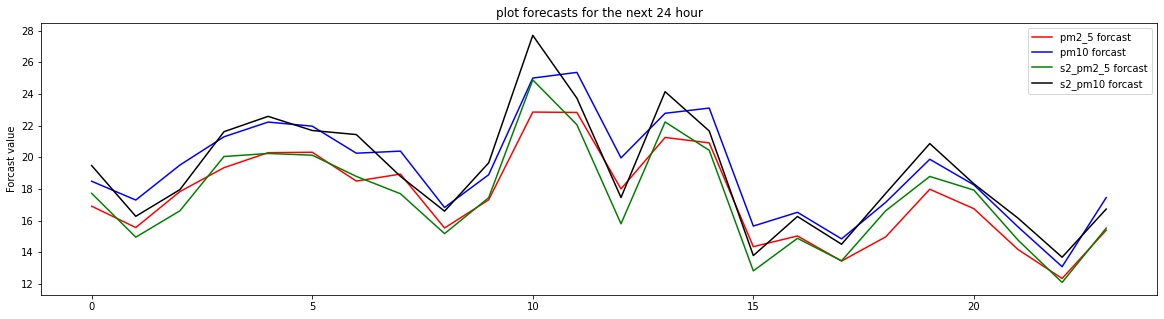

Site : 689525


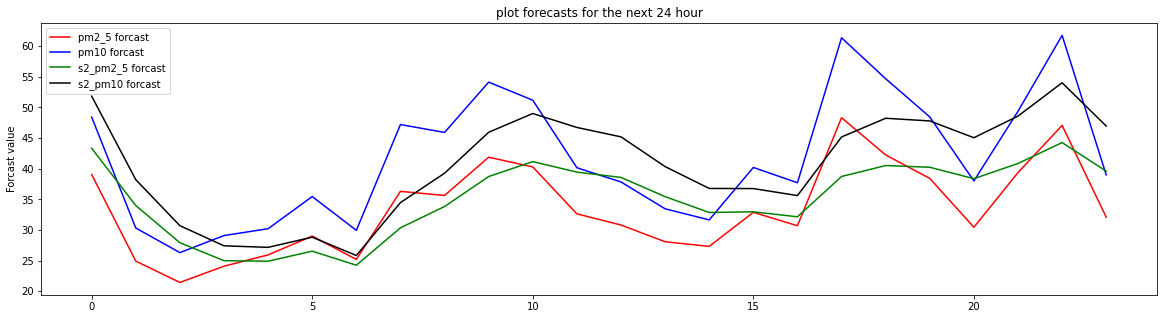

Site : 689530


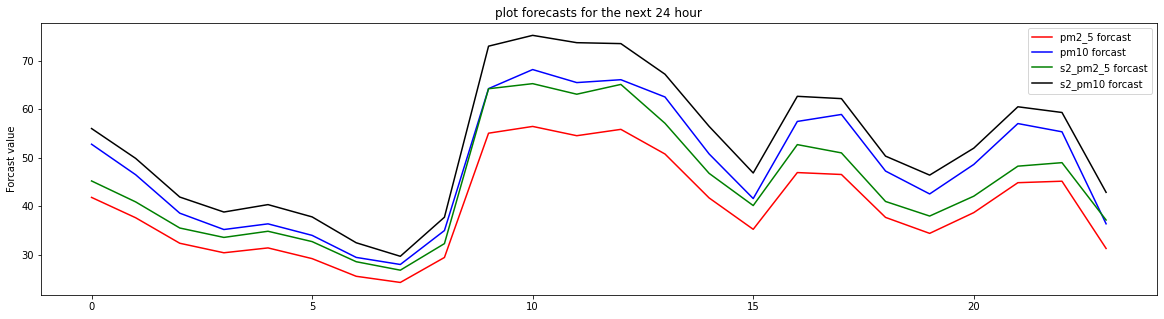

Site : 689750


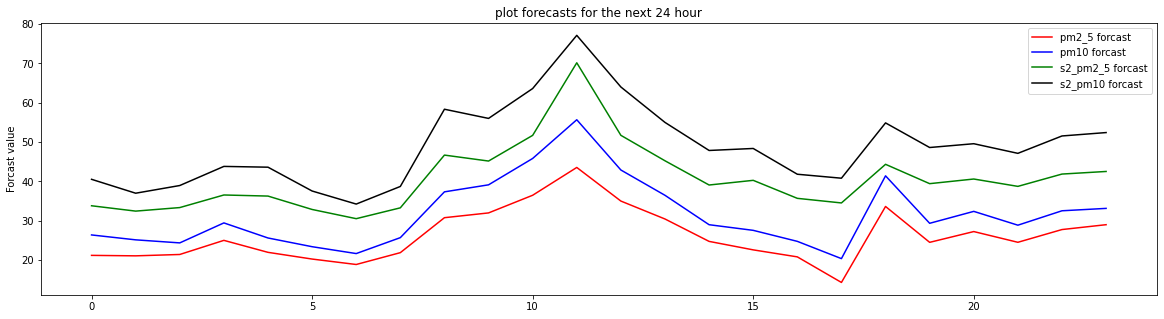

Site : 689752


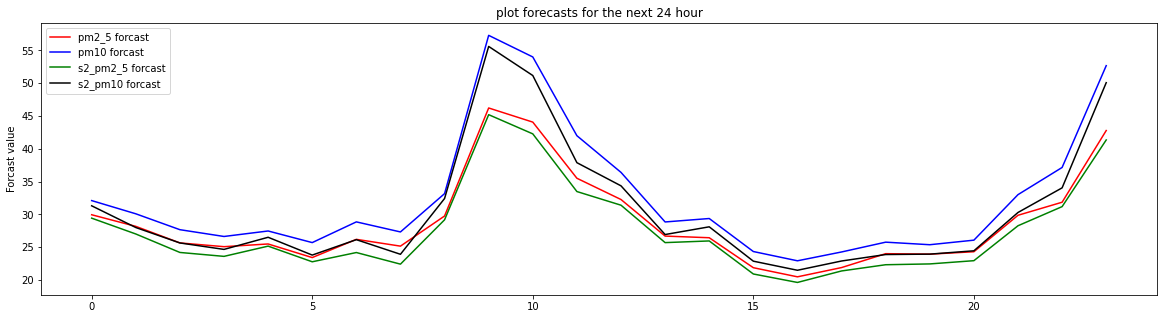

Site : 689753


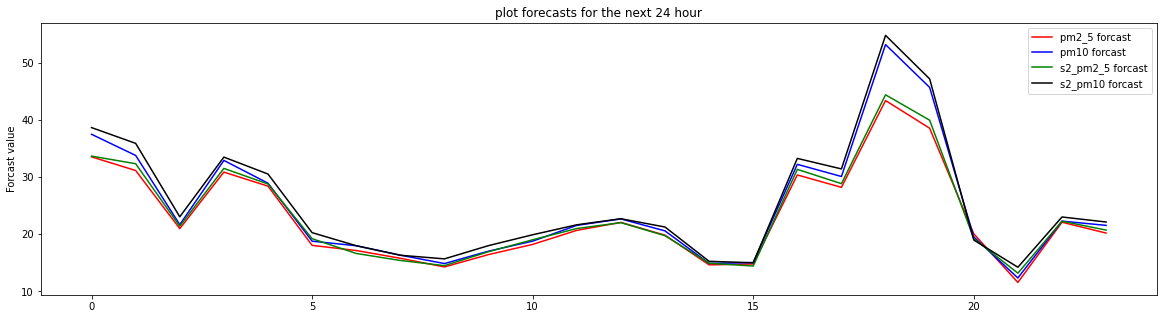

Site : 689756


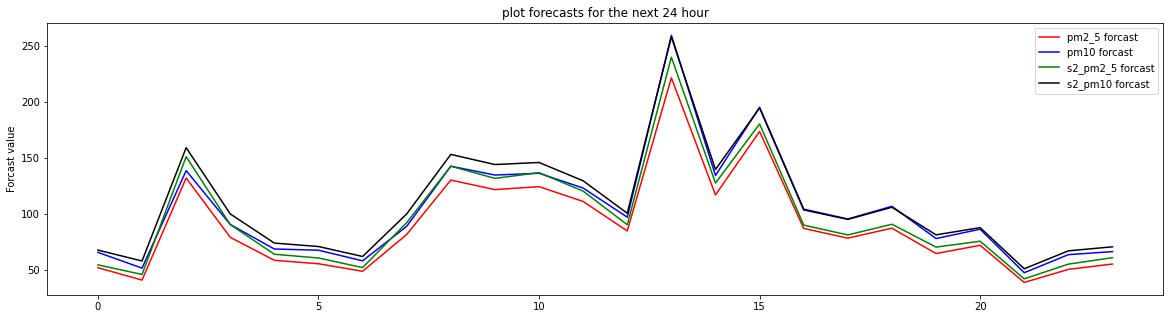

Site : 689761


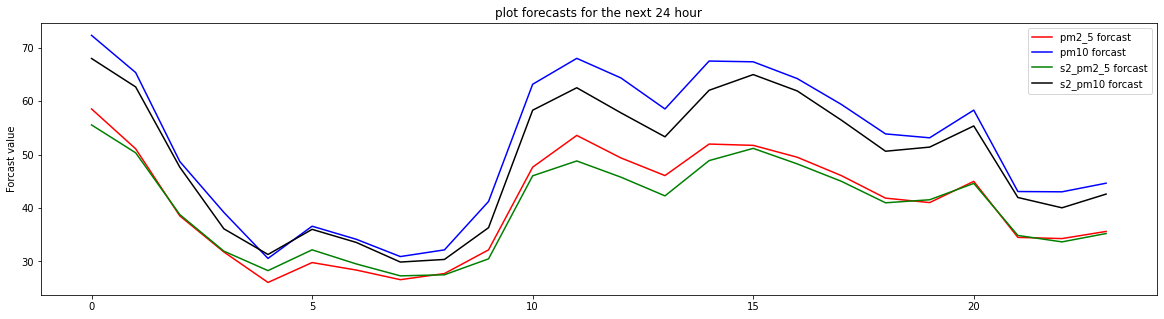

Site : 730019


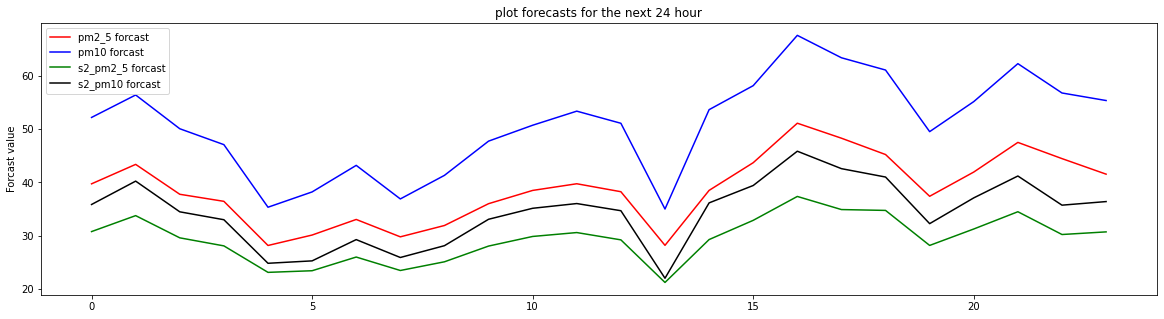

Site : 737273


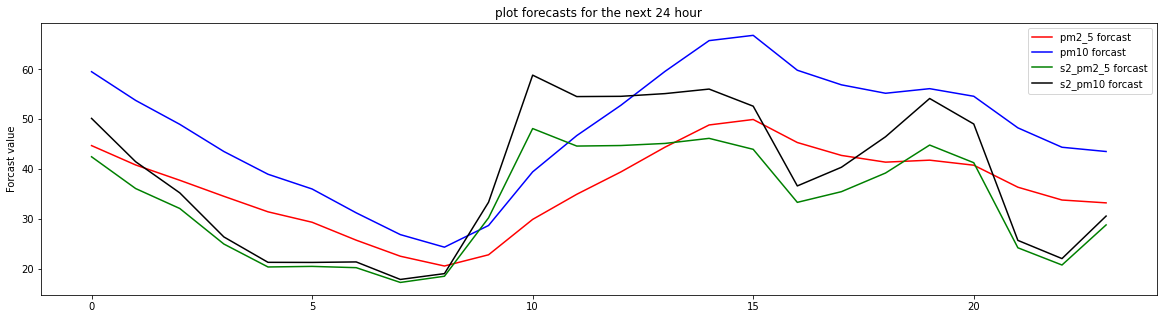

Site : 832252


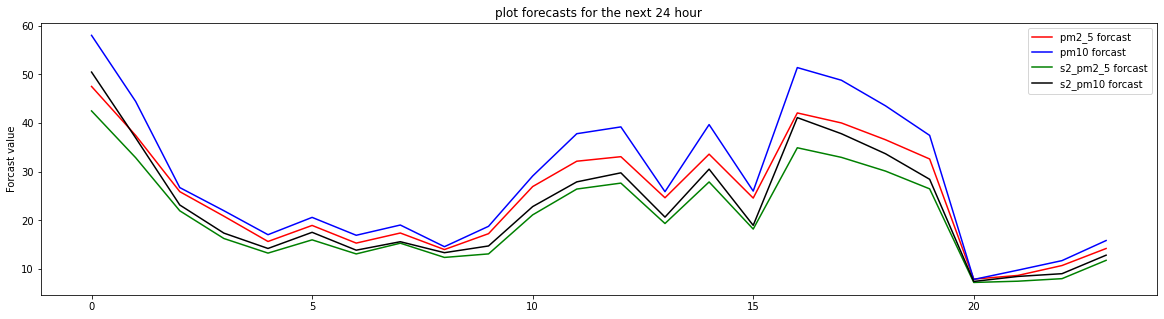

Site : 870140


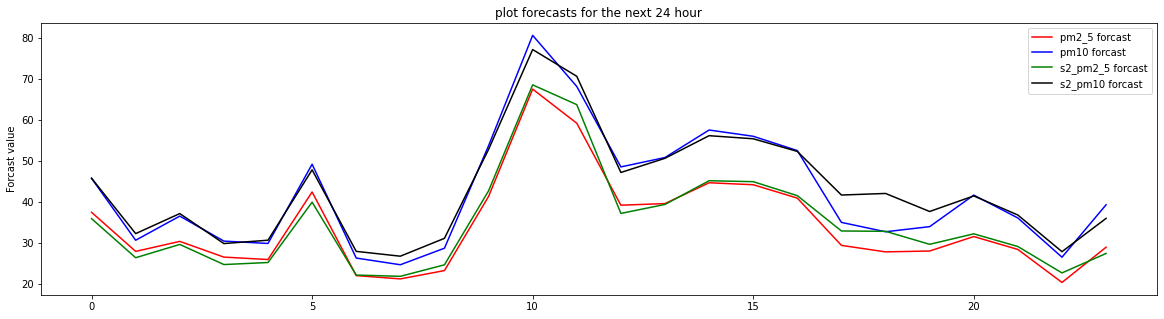

Site : 870142


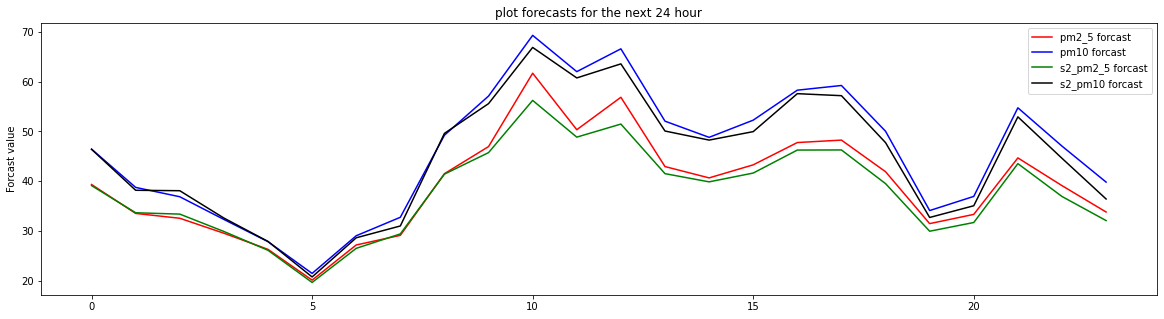

Site : 870147


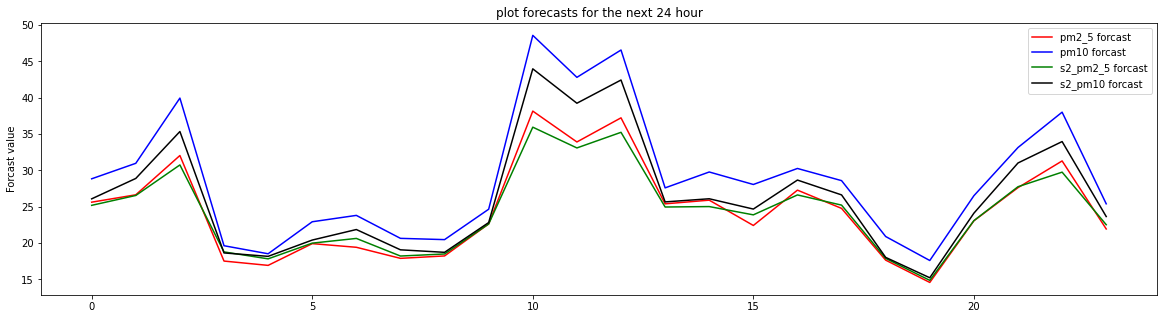

Site : 912219


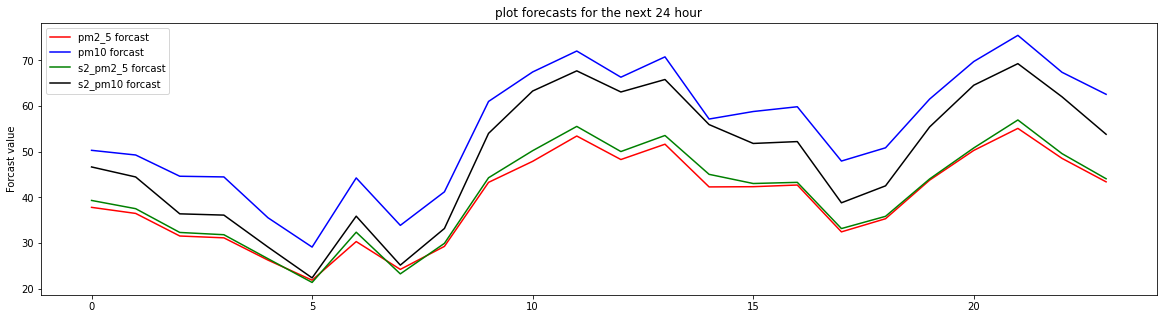

Site : 912225


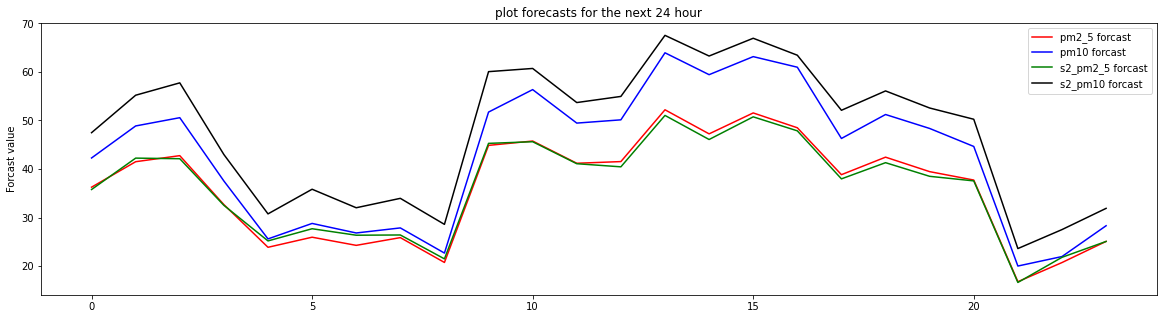

Site : 930426


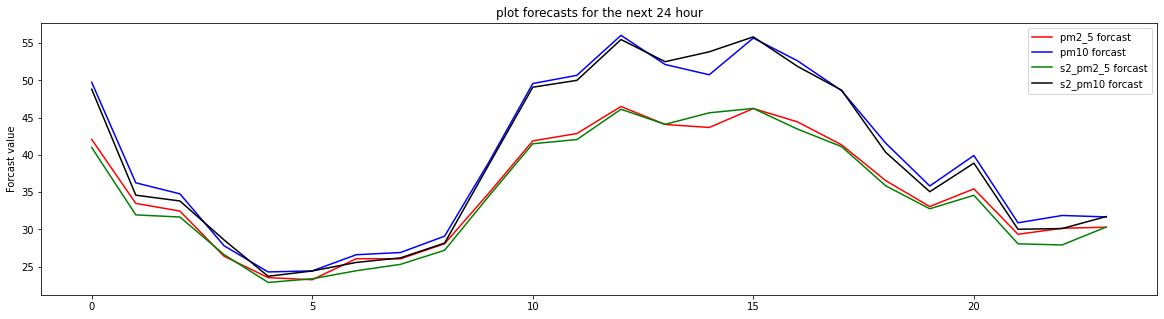

Site : 672528


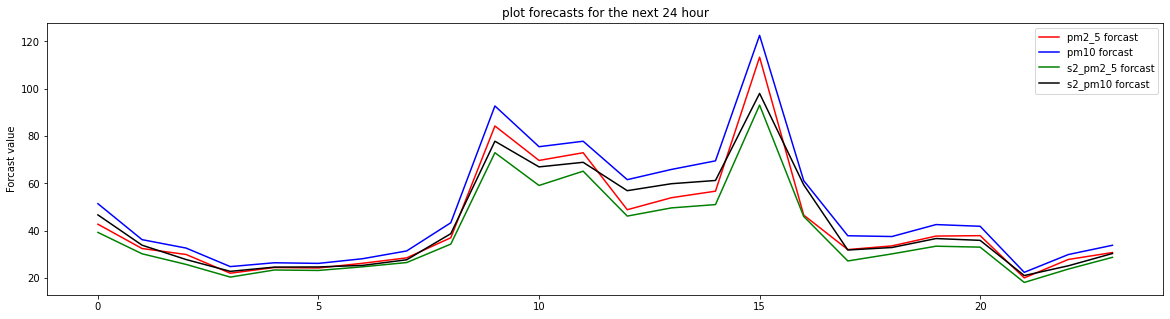

Site : 675801


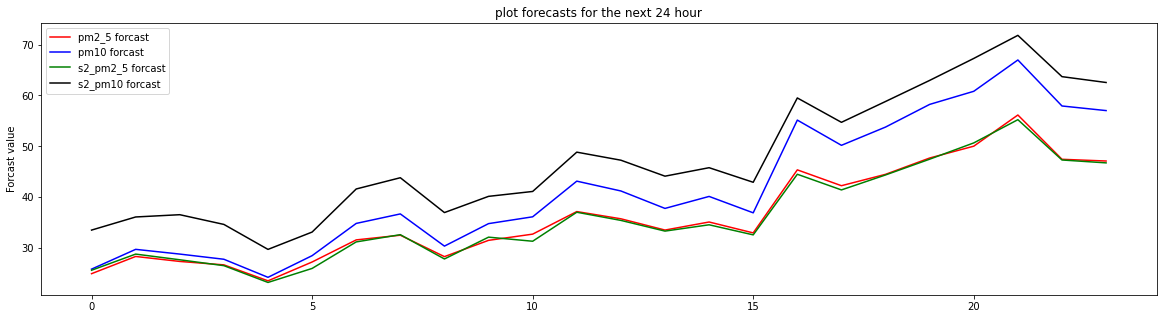

Site : 675805


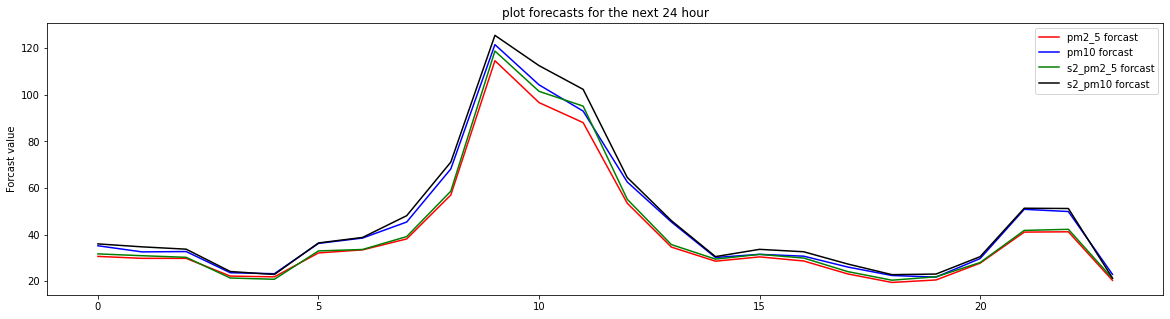

Site : 675991


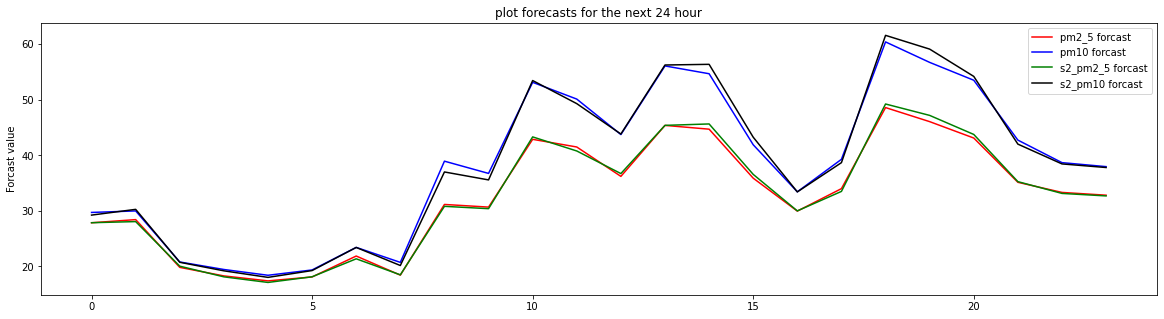

Site : 832253


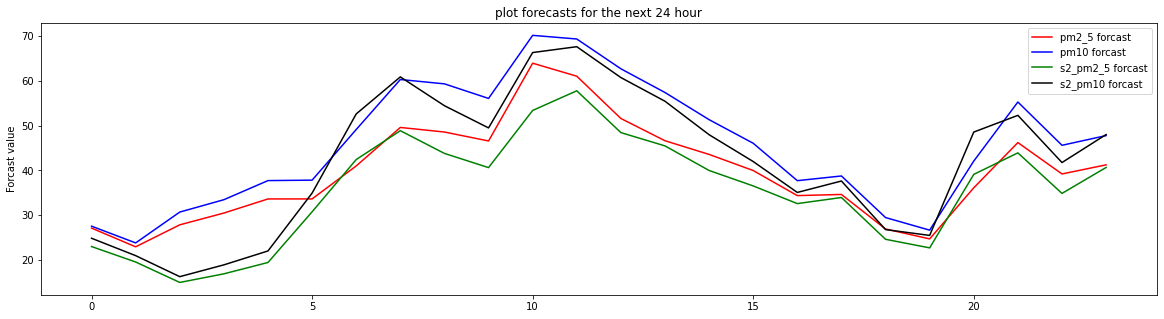

Site : 870143


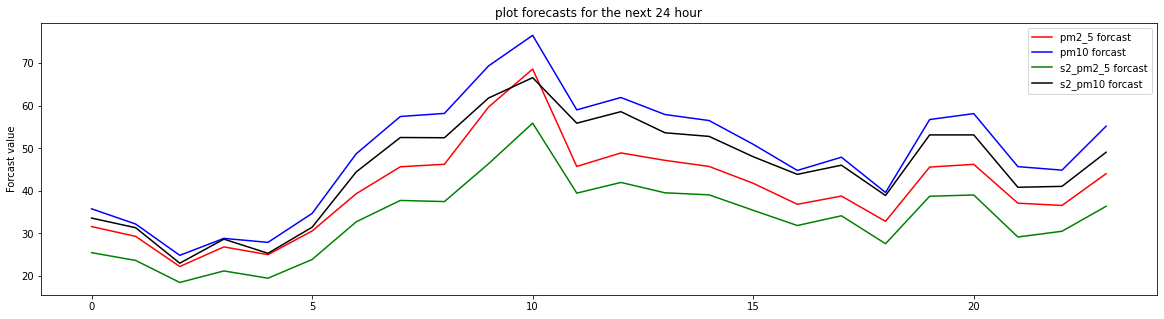

Site : 689516


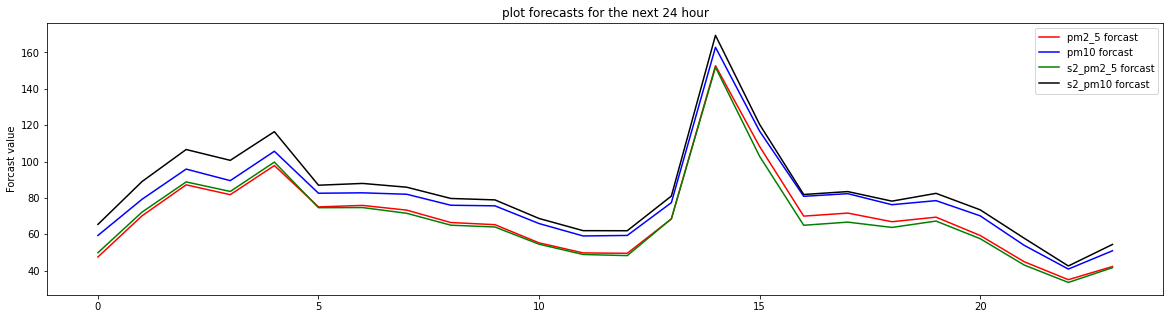

Site : 689759


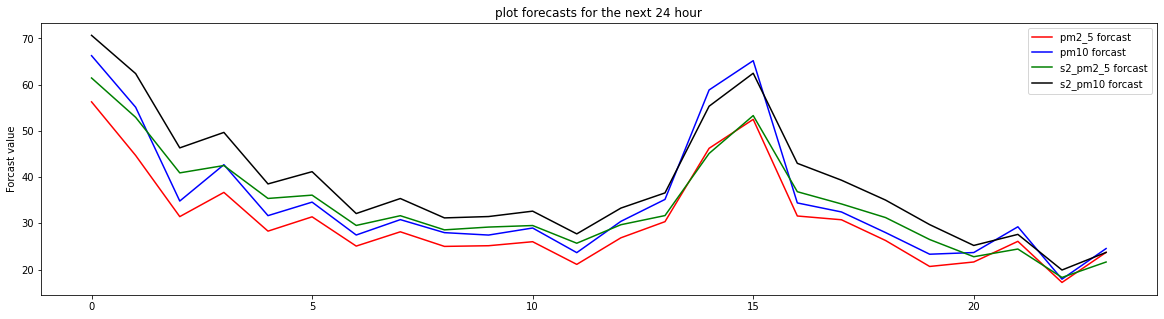

Site : 676000


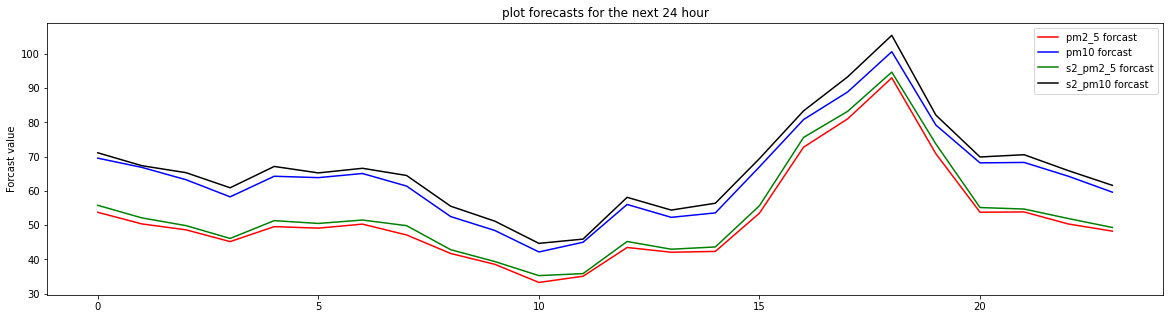

Site : 718028


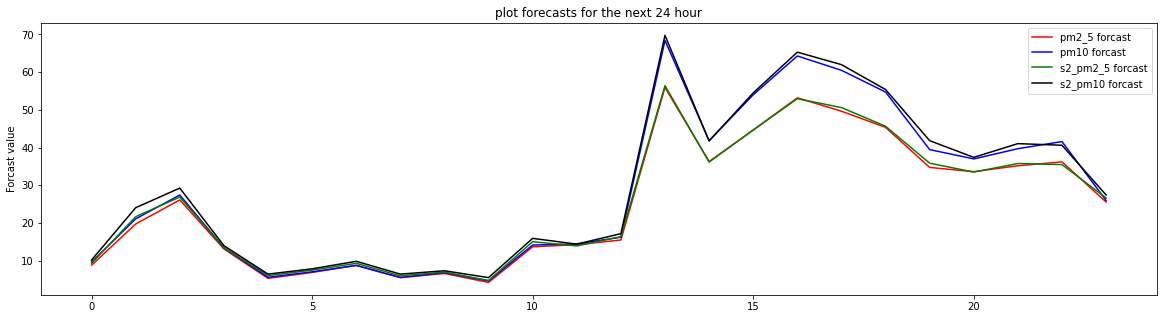

Site : 730016


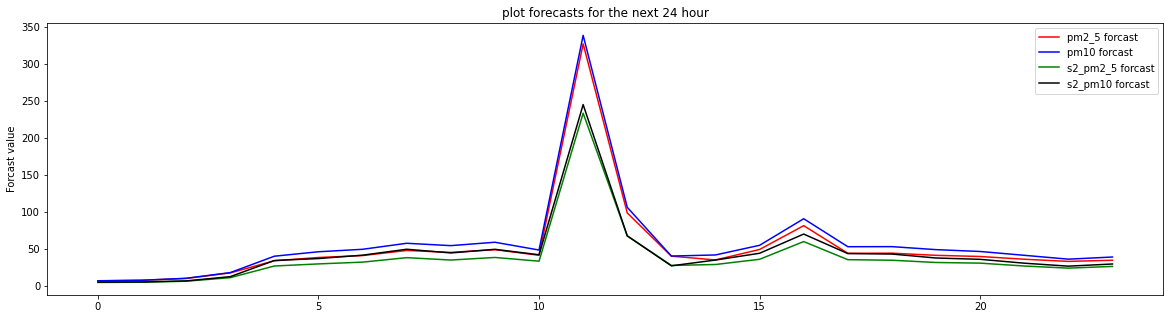

Site : 755612


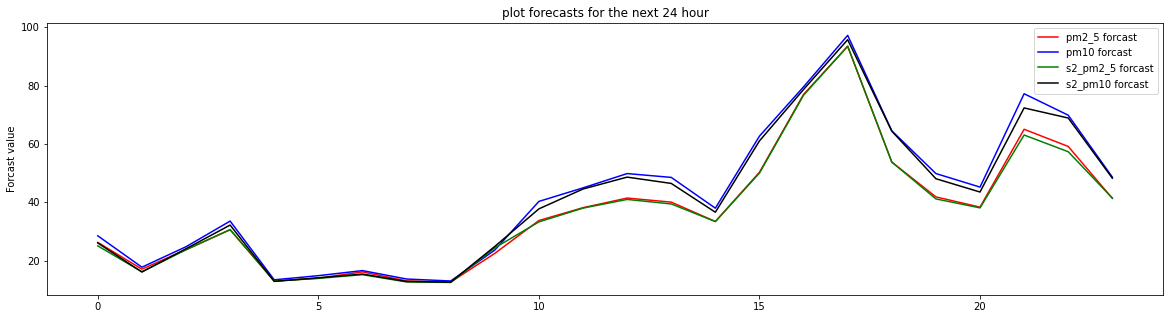

Site : 755614


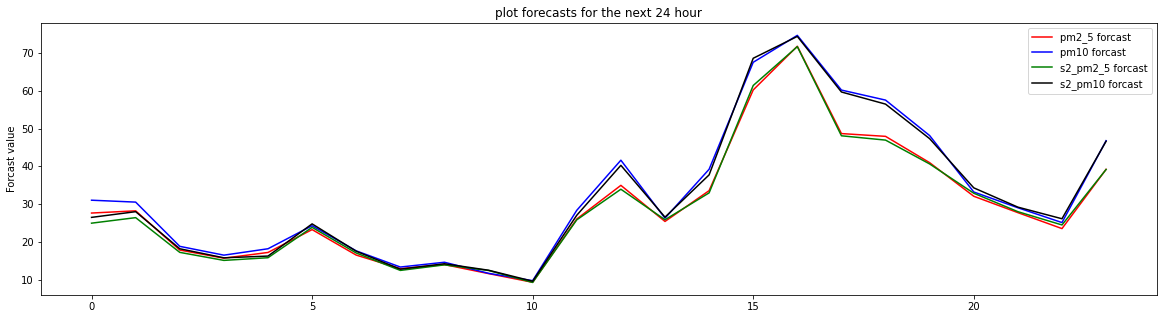

Site : 782718


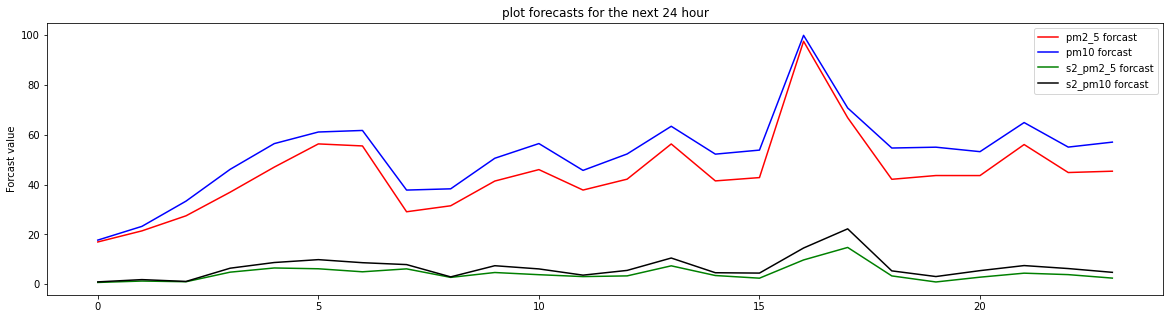

Site : 782722


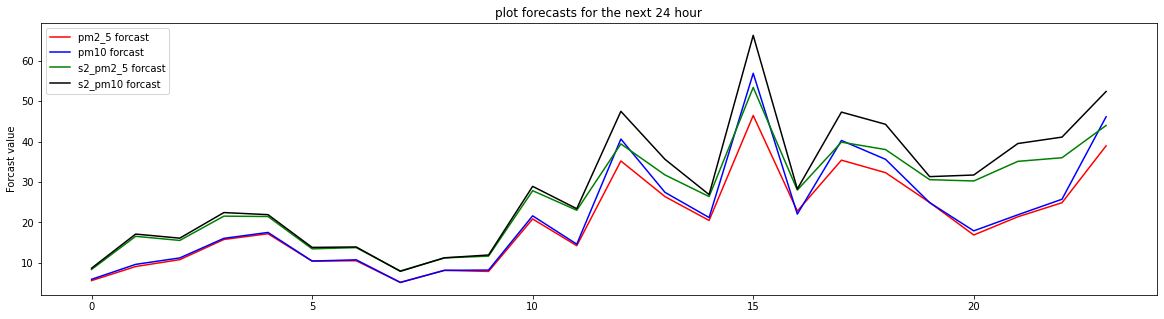

Site : 832254


In [ ]:
for channel_id in rigth_dataset_['channel_id'].unique():
    forcast_sites(channel_id,rigth_dataset_)